In [1]:
## Scraping College Football Major Conference Membership Data from Wikipedia

# Dependencies
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import json
import re

import matplotlib.pyplot as plt



In [2]:
## New Block - Download and clean table of all FBS and FCS Teams
## directly from NCAA.com

## Division 1 - FCS (Football Championship Subdivision) URL - returns JSON
fcs_url = 'https://web3.ncaa.org/directory/api/directory/memberList?type=12&division=I-FCS&sportCode=MFB&_=1695167370986'

## Division 1 - FBS (Football Bowl Subdivision) URL
fbs_url = 'https://web3.ncaa.org/directory/api/directory/memberList?type=12&division=I-FBS&sportCode=MFB&_=1695166960182'

# get the FCS data
fcs_response = requests.get(fcs_url)
fcs_list = json.loads(fcs_response.text) # load the JSON
fcs_df = pd.DataFrame(fcs_list) # to dataframe

# get the FBS data
fbs_response = requests.get(fbs_url)
fbs_list = json.loads(fbs_response.text) # load the JSON
fbs_df = pd.DataFrame(fbs_list) # to dataframe

# Concatenate the FCS and FBS dataframes
ncaa_df = pd.concat([fcs_df, fbs_df], ignore_index=True)

# drop columns that have nan values
df = ncaa_df.dropna(axis=1, how='all')
# Extracting the 'state' key from the 'memberOrgAddress' column and creating a new column 'state'
df['state'] = df['memberOrgAddress'].apply(lambda x: x.get('state', None) if isinstance(x, dict) else None)

# Dropping the 'memberOrgAddress' column
df.drop('memberOrgAddress', axis=1, inplace=True)

## keep columns
keep_col = ['nameOfficial', 'division', 'subdivision', 'conferenceId', 'conferenceName', 
            'reclassYear',  'reclassDivision', 'reclassSubdivision',
            'privateFlag', 'historicallyBlackFlag', 'sportRegion', 'state']

# keep just the columns we want
df = df[keep_col]

rename_col = ['name', 'division', 'subdivision', 'conference_id', 'conference_name',
                'reclass_year', 'reclass_division', 'reclass_subdivision',
                'private', 'historically_black', 'region', 'state']
# remap the subdivision values 1 to FBS and 2 to FCS
df['subdivision'] = df['subdivision'].map({1: 'FBS', 2: 'FCS'})

# rename columns
df.columns = rename_col

df.head()

# save csv file
df.to_csv('../data/ncaa_com_fbs_fcs_table.csv', index=False)

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2970117950.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = df['memberOrgAddress'].apply(lambda x: x.get('state', None) if isinstance(x, dict) else None)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2970117950.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('memberOrgAddress', axis=1, inplace=True)


In [3]:
########## NEW BLOCK 9-15-23 ##########
### Use Wiki list of Division 1 FBS programs to get list of all conferences
### Extract all links from Former Conferences column and store in dataframe of conference, wiki_link

# URL of page to be scraped
url = 'https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_programs'

# Retrieve page with the requests module
response = requests.get(url)

# Create BeautifulSoup object; parse with 'lxml'
soup = BeautifulSoup(response.text, 'lxml')
# extract Former Conferences column from table
table = soup.find('table', class_='wikitable sortable')

In [4]:
# create empty lists to store conference and wiki_link
conferences = []
wiki_links = []
rows = table.findAll('tr')

# Loop through the rows to extract data
for row in rows[1:]:  # Skip header row
    cells = row.findAll('td')
    
    if len(cells) > 6:  # Ensure there are enough columns to extract "Former Conferences"
        conf_cell = cells[6]
        
        # Find all the links within the "Former Conferences" cell
        links = conf_cell.findAll('a')
        
        # If there are links, extract conference name and link
        if links:
            for link in links:
                conferences.append(link.text)
                wiki_links.append(link.get('href'))
        else:
            # Extract plain text conferences without links
            conf_texts = conf_cell.get_text(separator="|").split('|')
            for conf in conf_texts:
                conferences.append(conf.strip())
                wiki_links.append(np.nan)

# Create a DataFrame
conf_df = pd.DataFrame({'conference': conferences, 'wiki_link': wiki_links})

# Convert the 'conference' column to string type
conf_df['conference'] = conf_df['conference'].astype(str)

# Now remove citation numbers from conference names
conf_df['conference'] = conf_df['conference'].str.replace(r"\[.*\]", "")

# Drop duplicates
conf_df.drop_duplicates(inplace=True)
# Drop any rows with NaN values in wiki_link column
conf_df.dropna(subset=['wiki_link'], inplace=True)
# Drop any rows with empty strings in conference column
conf_df = conf_df[conf_df['conference'] != '']
# sort alphabetically
conf_df.sort_values(by=['conference'], inplace=True)
# If the wiki_link coumn matches and existing row in the dataframe, drop it
conf_df.drop_duplicates(subset=['wiki_link'], keep='first', inplace=True)
# If the conference column matches and existing row in the dataframe, drop it
conf_df.drop_duplicates(subset=['conference'], keep='first', inplace=True)
# Display the first 20 rows of the dataframe
conf_df.tail(20)

len(conf_df)




C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\919811544.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  conf_df['conference'] = conf_df['conference'].str.replace(r"\[.*\]", "")


65

In [5]:
conf_df.tail(40)
# conf_df.head(20)
# add the wiki link to the end of the wikipedia url
conf_df['wiki_link'] = 'https://en.wikipedia.org' + conf_df['wiki_link']

conf_df.head(20)


,conference,wiki_link
301,A-10,https://en.wikipedia.org/wiki/Atlantic_10_Conf...
147,ACC,https://en.wikipedia.org/wiki/Atlantic_Coast_C...
103,ASUN,https://en.wikipedia.org/wiki/ASUN_Conference
97,Alabama Intercollegiate/Collegiate,https://en.wikipedia.org/wiki/Southern_States_...
88,American,https://en.wikipedia.org/wiki/American_Athleti...
107,Atlantic 10,https://en.wikipedia.org/wiki/Atlantic_10_Conf...
8,BIAA,https://en.wikipedia.org/wiki/Border_Intercoll...
52,Big 12,https://en.wikipedia.org/wiki/Big_12_Conference
289,Big 4 Conference,https://en.wikipedia.org/wiki/Big_Four_Confere...
95,Big 8,https://en.wikipedia.org/wiki/Big_Eight_Confer...


In [6]:
## List of Current Conferences (2023) and their Wikipedia URLs
SEC = 'https://en.wikipedia.org/wiki/Southeastern_Conference'
ACC = 'https://en.wikipedia.org/wiki/Atlantic_Coast_Conference'
B1G = 'https://en.wikipedia.org/wiki/Big_Ten_Conference'
PAC12 = 'https://en.wikipedia.org/wiki/Pac-12_Conference'
BIG12 = 'https://en.wikipedia.org/wiki/Big_12_Conference'
AAC = 'https://en.wikipedia.org/wiki/American_Athletic_Conference'
MWC = 'https://en.wikipedia.org/wiki/Mountain_West_Conference'
MAC = 'https://en.wikipedia.org/wiki/Mid-American_Conference'
CUSA = 'https://en.wikipedia.org/wiki/Conference_USA'
SBC = 'https://en.wikipedia.org/wiki/Sun_Belt_Conference'


# Defunct Conferences That Have Been Major Conferences
SWC = 'https://en.wikipedia.org/wiki/Southwest_Conference'
BIG8 = 'https://en.wikipedia.org/wiki/Big_Eight_Conference'
BIGEAST = 'https://en.wikipedia.org/wiki/Big_East_Conference_(1979%E2%80%932013)'
IVY = 'https://en.wikipedia.org/wiki/Ivy_League'
PCC = 'https://en.wikipedia.org/wiki/Pacific_Coast_Conference'
BORDER = 'https://en.wikipedia.org/wiki/Border_Conference'
MVC = 'https://en.wikipedia.org/wiki/Missouri_Valley_Conference'
SKYLINE = 'https://en.wikipedia.org/wiki/Skyline_Conference_(1938%E2%80%931962)'
WAC = 'https://en.wikipedia.org/wiki/Western_Athletic_Conference_football'

# Create a dataframe of the above conferences and their wikipedia urls
existing_urls = pd.DataFrame({'conference': ['SEC', 'ACC', 'B1G', 'PAC12', 'BIG12', 'AAC', 'MWC', 'MAC', 'CUSA', 'SBC', 'SWC', 'BIG8', 'BIGEAST', 'IVY', 'PCC', 'BORDER', 'MVC', 'SKYLINE', 'WAC'],
                          'wiki_link': [SEC, ACC, B1G, PAC12, BIG12, AAC, MWC, MAC, CUSA, SBC, SWC, BIG8, BIGEAST, IVY, PCC, BORDER, MVC, SKYLINE, WAC]})

# add the conf_df to the existing_urls dataframe
conf_df = pd.concat([conf_df, existing_urls], ignore_index=True)

# drop any rows that are duplicates in the wiki_link column
conf_df.drop_duplicates(subset=['wiki_link'], keep='first', inplace=True)

# sort alphabetically
conf_df.sort_values(by=['conference'], inplace=True)

conf_df.head(15)

len(conf_df)






71

In [7]:
conf_df.tail(25)

# Save as csv for manual inspection
conf_df.to_csv('../TEMP/conference_wiki_links.csv', index=False)

In [8]:
## Put the URLs into a list and check them for status codes
urls = [SEC, ACC, B1G, PAC12, BIG12, AAC, MWC, MAC, CUSA, SBC, SWC, WAC, BIG8, BIGEAST, IVY, PCC, BORDER, MVC, SKYLINE, WAC]

# put the list of urls into a for loop to check the status code
for url in urls:
    response = requests.get(url)
    print(f"{url} status code: {response.status_code}")

https://en.wikipedia.org/wiki/Southeastern_Conference status code: 200
https://en.wikipedia.org/wiki/Atlantic_Coast_Conference status code: 200
https://en.wikipedia.org/wiki/Big_Ten_Conference status code: 200
https://en.wikipedia.org/wiki/Pac-12_Conference status code: 200
https://en.wikipedia.org/wiki/Big_12_Conference status code: 200
https://en.wikipedia.org/wiki/American_Athletic_Conference status code: 200
https://en.wikipedia.org/wiki/Mountain_West_Conference status code: 200
https://en.wikipedia.org/wiki/Mid-American_Conference status code: 200
https://en.wikipedia.org/wiki/Conference_USA status code: 200
https://en.wikipedia.org/wiki/Sun_Belt_Conference status code: 200
https://en.wikipedia.org/wiki/Southwest_Conference status code: 200
https://en.wikipedia.org/wiki/Western_Athletic_Conference_football status code: 200
https://en.wikipedia.org/wiki/Big_Eight_Conference status code: 200
https://en.wikipedia.org/wiki/Big_East_Conference_(1979%E2%80%932013) status code: 200
https

In [9]:
# MAC - Mid American Conference

# Use beautiful soup to parse the HTML and extract tables
response = requests.get(MAC)
soup = BeautifulSoup(response.text, 'html.parser')
tables = soup.find_all('table', class_='wikitable sortable')

# read tables into pandas
current = pd.read_html(str(tables[0]))[0]

# Manually create the former conference members dataframe
# Insitution, Location, Founded, Joined, Left, Nickname

# Create the empty dataframe
MAC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 
                            'Joined', 'Left', 'Enrollment', 'Conference'])

# New dataframe of former members
former = pd.DataFrame({'Institution': ['Butler University', 'University of Cincinnati', 'Marshall University', 'Marshall University', 'Wayne State University', 'Western Reserve University'],
                          'Location': ['Indianapolis, IN', 'Cincinnati, OH', 'Huntington, WV', 'Huntington, WV', 'Detroit, MI', 'Cleveland, OH'],
                            'Founded': [1855, 1819, 1837, 1837, 1868, 1826],
                            'Joined': [1946, 1946, 1954, 1997, 1946, 1946],
                            'Left': [1950, 1953, 1969, 2005, 1947, 1955],
                            'Nickname': ['Bulldogs', 'Bearcats', 'Thundering Herd', 'Thundering Herd', 'Tartars', 'Red Cats']})

# Clean the current members dataframe
# Rename the column headers
col_names = ['Institution', 'Location', 'Founded', 'Joined', 'Type', 'Enrollment',
             'Endowment', 'Nickname', 'Colors', 'drop']
current.columns = col_names
# Drop row with West Division in the Insitution column
current = current[current.Institution != 'West Division']
# Drop the Northern Illinois row that has errors - will recreate later
current = current[current.Institution != 'Northern Illinois University']

# Rename University at Buffalo to University of Buffalo
current.Institution = current.Institution.replace('University at Buffalo', 'University of Buffalo')

# Rename Miamai University to Miami (OH)
current.Institution = current.Institution.replace('Miami University', 'Miami (OH)')

# # Create new rows
new_row1 = {'Institution': 'Northern Illinois University', 'Location': 'DeKalb, IL', 'Founded': 1895, 'Joined': 1997, 'Type': 'Public', 'Enrollment': 19600, 'Endowment': 100000000, 'Nickname': 'Huskies', 'Colors': 'Cardinal and Black', 'drop': np.nan}
new_row2 = {'Institution': 'Northern Illinois University', 'Location': 'DeKalb, IL', 'Founded': 1895, 'Joined': 1975, 'Left': 1986, 'Type': 'Public', 'Enrollment': 19600, 'Endowment': 100000000, 'Nickname': 'Huskies', 'Colors': 'Cardinal and Black', 'drop': np.nan}
# add rows to the dataframe
former = former.append(new_row1, ignore_index=True)
former = former.append(new_row2, ignore_index=True)

# Combine the current and former dataframes into one
MAC = pd.concat([current, former], ignore_index=True)

# Add the conference column
MAC['Conference'] = 'Mid-American Conference'

# Keep only the columns we want
MAC = MAC[['Institution', 'Nickname', 'Location', 'Founded', 
           'Joined', 'Left', 'Enrollment', 'Conference']]

current 

former

# Save the dataframe to a csv file
MAC.to_csv('..\TEMP\conference_data\MAC.csv', index=False)

# MAC
# Create dataframe of current members


C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2841414385.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  former = former.append(new_row1, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2841414385.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  former = former.append(new_row2, ignore_index=True)


In [10]:
## Working - Output aved in directory: conference_data


# Extract and clean SEC data
SEC_TABLES = pd.read_html(SEC)
current = SEC_TABLES[2]
future = SEC_TABLES[3].head()

# Drop Columns and standardized names
# Keep Institution, Nickname, Location, Founded, Joined, Enrollment

# Clean the current membership table

# Flatten multi-level headers
current.columns = [' '.join(col).strip() for col in current.columns.values]

# As a demo, we will now drop the columns that aren't part of the standardized dataframe
standard_columns = ['Institution East Division', 'Nickname East Division', 'Location East Division', 
                    'Founded East Division', 'Joined East Division']
current = current[standard_columns]

# Renaming for standardization
rename_map = {
    'Institution East Division': 'Institution',
    'Nickname East Division': 'Nickname',
    'Location East Division': 'Location',
    'Founded East Division': 'Founded',
    'Joined East Division': 'Joined',
    'Enrollment East Division': 'Enrollment'
}

# Rename columns
current = current.rename(columns=rename_map)

# keep_col = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Enrollment']
# current = current[keep_col]


keep_col_2 = ['Institution', 'Nickname', 'Location', 'Founded', 'Join Date', 'Enrollment']
future = future[keep_col_2]

# Rename Join Date to Joined
future = future.rename(columns={'Join Date': 'Joined'})

# Create empty stadard dataframe
SEC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 
                            'Joined', 'Left', 'Enrollment', 'Conference'])

# combine the two dataframes into the new standard dataframe
SEC = SEC.append(current)

# add the future dataframe to the standard dataframe
SEC = SEC.append(future)

# Drop the row that says West Division
SEC = SEC[SEC['Institution'] != 'West Division']

# Add SEC to the Conference Column
SEC['Conference'] = 'SEC'

# # Clean Enrollment Column
# SEC['Enrollment'] = SEC['Enrollment'].str.replace(',', '') # Remove commas
# SEC['Enrollment'] = SEC['Enrollment'].str.replace('\[.*\]', '') # Remove references

# # Fill na values with 0
# SEC['Enrollment'] = SEC['Enrollment'].fillna(0)
# # Store as integer
# SEC['Enrollment'] = SEC['Enrollment'].astype(int)


SEC.head(20)


# Save output to csv
SEC.to_csv('..\TEMP\conference_data\SEC.csv', index=False)



# SEC


# # future.columns

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\4045068338.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SEC = SEC.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\4045068338.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SEC = SEC.append(future)


In [11]:
## Extract and Clean ACC Data

ACC_TABLES = pd.read_html(ACC)
current = ACC_TABLES[1]
future = ACC_TABLES[2] # Joining to Joined
former = ACC_TABLES[3] # 

# Rename future Joining to Joined
future = future.rename(columns={'Joining': 'Joined'})
# Remove citation numbers from Enrollment
future['Enrollment'] = future['Enrollment'].str.replace(r"\[.*\]", "")


# Clean up the Joined Column with regex to remove the citation numbers
current['Joined'] = current['Joined'].str.replace(r"\[.*\]", "")

# Drop Columns and standardized names 
# Standard Table:  Institution, Nickname, Location, Founded, Joined, Left, Enrollment, Conference
# Combine into single dataframe that includes current, future, and former

keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment']

ACC = pd.DataFrame(columns=keep_cols)

# Concatenate the three dataframes
ACC = ACC.append(current)
ACC = ACC.append(future)
ACC = ACC.append(former)

# Keep only the columns in list
ACC = ACC[keep_cols]

# Clean up Enrollment column
ACC['Enrollment'] = ACC['Enrollment'].str.replace(r"\[.*\]", "")
# Remove commas
ACC['Enrollment'] = ACC['Enrollment'].str.replace(',', '')
# Make sure it is numeric
ACC['Enrollment'] = pd.to_numeric(ACC['Enrollment'])
# Fill NaN with 0
ACC['Enrollment'] = ACC['Enrollment'].fillna(0)
# store as int
ACC['Enrollment'] = ACC['Enrollment'].astype(int)

# Rename Miami to Miami (FL)
ACC['Institution'] = ACC['Institution'].replace('University of Miami', 'Miami (FL)')
# Rename to Virginia Tech
ACC['Institution'] = ACC['Institution'].replace('Virginia Polytechnic Institute and State University', 'Virginia Tech')
# Rename Maryland to University of Maryland
ACC['Institution'] = ACC['Institution'].replace('University of Maryland, College Park', 'University of Maryland')
# Rename SOuthern Methodist University to SMU
ACC['Institution'] = ACC['Institution'].replace('Southern Methodist University', 'SMU')
# University of North Carolina at Chapel Hill to University of North Carolina
ACC['Institution'] = ACC['Institution'].replace('University of North Carolina at Chapel Hill', 'University of North Carolina')
# Georgia Institute of Technology to Georgia Tech
ACC['Institution'] = ACC['Institution'].replace('Georgia Institute of Technology', 'Georgia Tech')




# Add the Conference column
ACC['Conference'] = 'ACC'


## Save output to csv
ACC.to_csv('..\TEMP\conference_data\ACC.csv', index=False)
# ACC.info()

future
# current
# former

# ACC

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2552304461.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  future['Enrollment'] = future['Enrollment'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2552304461.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  current['Joined'] = current['Joined'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2552304461.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ACC = ACC.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2552304461.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ACC = ACC.append(future)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2552304461.py:28: Future

,Institution,Location,Joined,Founded,Type,Enrollment,Endowment(millions),Nickname,Colors,Current Conference
0,Southern Methodist University,"Dallas, Texas[a]",2024,1911,Private (Methodist),"12,373","$2,000",Mustangs,NaN,American
1,"University of California, Berkeley","Berkeley, California",2024,1868,Public,"45,307","$6,910[24]",Golden Bears,NaN,Pac-12
2,Stanford University,"Stanford, California",2024,1891,Private (non-sectarian),"17,326","$37,800",Cardinal,NaN,Pac-12


In [12]:
# ACC

In [13]:
## BIG 12

BIG12_TABLES = pd.read_html(BIG12)

current = BIG12_TABLES[1]
future = BIG12_TABLES[2]
former = BIG12_TABLES[4]

# Remover citation numbers from Left column in former
former['Left'] = former['Left'].str.replace(r"\[.*\]", "")
# Remove citation numbers from Enrollment in all three
# current['Enrollment'] = current['Enrollment'].str.replace(r"\[.*\]", "")
# future['Enrollment'] = future['Enrollment'].str.replace(r"\[.*\]", "")
# former['Enrollment'] = former['Enrollment'].str.replace(r"\[.*\]", "")
# Assign a Joined date to future
future['Joined'] = '2024'

# Create a standard dataframe
BIG12 = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Concatenate the three dataframes
BIG12 = BIG12.append(current)
BIG12 = BIG12.append(future)
BIG12 = BIG12.append(former)

# Remove any citations from Institution column
BIG12['Institution'] = BIG12['Institution'].str.replace(r"\[.*\]", "")

# Add the conference name to the Conference column
BIG12['Conference'] = 'Big 12'
# Save output to csv
BIG12.to_csv('..\TEMP\conference_data\BIG12.csv', index=False)

# BIG12

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2146764393.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  former['Left'] = former['Left'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2146764393.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BIG12 = BIG12.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2146764393.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BIG12 = BIG12.append(future)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2146764393.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BIG12 = BIG12.append(former)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2146764393.py:27: FutureW

In [14]:
# Mountain West Conference


MWC_TABLES = pd.read_html(MWC)
current = MWC_TABLES[1]
former = MWC_TABLES[3]

# Create the Standard Dataframe
MWC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine the two dataframes into standard dataframe with the keep_cols
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

MWC = MWC.append(current)
MWC = MWC.append(former)
# Add conference name to Conference column
MWC['Conference'] = 'Mountain West Conference'
# keep only the columns in the keep_cols list
MWC = MWC[keep_cols]

# Save to csv
MWC.to_csv('..\TEMP\conference_data\MWC.csv', index=False)


# MWC
# current
# # former

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\1246314692.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MWC = MWC.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\1246314692.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  MWC = MWC.append(former)


In [15]:
# Conference USA

CUSA_TABLES = pd.read_html(CUSA)
current = CUSA_TABLES[1]
future = CUSA_TABLES[3] 
former = CUSA_TABLES[4]

# Create the Standard Dataframe
CUSA = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The three dataframes into the standard dataframe
CUSA = CUSA.append(current)
CUSA = CUSA.append(future)
CUSA = CUSA.append(former)

# Remove citation numbers from Joined and Left columns
CUSA['Joined'] = CUSA['Joined'].str.replace(r"\[.*\]", "")
CUSA['Enrollment'] = CUSA['Enrollment'].str.replace(r"\[.*\]", "")
# Remove commas
CUSA['Enrollment'] = CUSA['Enrollment'].str.replace(',', '')
# Fill NaN with 0
CUSA['Enrollment'] = CUSA['Enrollment'].fillna(0)
# store as int
CUSA['Enrollment'] = CUSA['Enrollment'].astype(int)

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

CUSA = CUSA[keep_cols]

# Add conference name to Conference column
CUSA['Conference'] = 'Conference USA'

# Save to csv
CUSA.to_csv('..\TEMP\conference_data\CUSA.csv', index=False)

# CUSA


# current
# former

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\953154483.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CUSA = CUSA.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\953154483.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CUSA = CUSA.append(future)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\953154483.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CUSA = CUSA.append(former)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\953154483.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  CUSA['Joined'] = CUSA['Joined'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\953154483.py:18: FutureWarning: The

In [16]:
# CUSA

In [17]:
## Sun Belt Conference

SBC_TABLES = pd.read_html(SBC)
current = SBC_TABLES[1]
future = SBC_TABLES[2]
former = SBC_TABLES[3]

# Create the Standard Dataframe
SBC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The three dataframes into the standard dataframe
SBC = SBC.append(current)
SBC = SBC.append(future)
SBC = SBC.append(former)

# Remove citation numbers from Joined and Left columns
# Make sure all columns are strings
SBC['Founded'] = SBC['Founded'].astype(str)
SBC['Joined'] = SBC['Joined'].astype(str)
SBC['Enrollment'] = SBC['Enrollment'].astype(str)
SBC['Joined'] = SBC['Joined'].str.replace(r"\[.*\]", "")
SBC['Enrollment'] = SBC['Enrollment'].str.replace(r"\[.*\]", "")
SBC['Left'] = SBC['Left'].str.replace(r"\[.*\]", "")

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

# Add conference name to Conference column
SBC['Conference'] = 'Sun Belt Conference'

# Drop the row that says Public
SBC = SBC[SBC['Institution'] != 'Public']

# Take care of nan values in the Joined column
# SBC['Joined'] = SBC['Joined'].fillna(0)

# Make sure Joined, Founded and left are an int
#Need to convert to float first to get rid of the decimal
SBC['Joined'] = SBC['Joined'].astype(float)
SBC['Joined'] = SBC['Joined'].fillna(0)
SBC['Joined'] = SBC['Joined'].astype(int)

SBC['Founded'] = SBC['Founded'].astype(float)
SBC['Founded'] = SBC['Founded'].fillna(0)
SBC['Founded'] = SBC['Founded'].astype(int)

SBC['Left'] = SBC['Left'].astype(float)
SBC['Left'] = SBC['Left'].fillna(0)
SBC['Left'] = SBC['Left'].astype(int)


# Save to csv
SBC.to_csv('..\TEMP\conference_data\SBC.csv', index=False)

# current
# future
# # former
# SBC

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2653850380.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SBC = SBC.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2653850380.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SBC = SBC.append(future)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2653850380.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SBC = SBC.append(former)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2653850380.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  SBC['Joined'] = SBC['Joined'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2653850380.py:22: FutureWarning: The de

In [18]:
# Southwest Conference (Defunct)

SWC_TABLES = pd.read_html(SWC)
temp = SWC_TABLES[2]
final = SWC_TABLES[3]
# Rename Academic Year of Departure	to Left
final = final.rename(columns={'Academic Year of Departure': 'Left'})
temp = temp.rename(columns={'Academic Year of Departure': 'Left'})
# Remane Team to Institution
temp = temp.rename(columns={'Team': 'Institution'})
final = final.rename(columns={'Team': 'Institution'})

# make standard dataframe
SWC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine the two dataframes into the standard dataframe
SWC = SWC.append(temp)
SWC = SWC.append(final)

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

SWC = SWC[keep_cols]

# Add conference name to Conference column
SWC['Conference'] = 'Southwest Conference'

# Manually add the Joined date to schools 
SWC.loc[SWC['Institution'] == 'Arkansas', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'Baylor', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'Houston', 'Joined'] = 1976
SWC.loc[SWC['Institution'] == 'Rice', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'SMU', 'Joined'] = 1918
SWC.loc[SWC['Institution'] == 'TCU', 'Joined'] = 1923
SWC.loc[SWC['Institution'] == 'Texas', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'Texas A&M', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'Texas Tech', 'Joined'] = 1956
SWC.loc[SWC['Institution'] == 'Southwestern', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'Phillips', 'Joined'] = 1920
SWC.loc[SWC['Institution'] == 'Oklahoma', 'Joined'] = 1915
SWC.loc[SWC['Institution'] == 'Oklahoma A&M', 'Joined'] = 1915


# Save to csv
SWC.to_csv('..\TEMP\conference_data\SWC.csv', index=False)
# SWC
# # temp

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\770150982.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SWC = SWC.append(temp)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\770150982.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SWC = SWC.append(final)


In [19]:
# Western_Athletic_Conference

WAC_TABLES = pd.read_html(WAC)
current = WAC_TABLES[1]
former = WAC_TABLES[2]

# rename columns - First Year to Joined, Last Year to Left
current = current.rename(columns={'First Year': 'Joined', 'Last Year': 'Left'})

# Fix Team Name - Split them into Institution and Nickname

def split_team_name(team_name):
    words = team_name.split()
    
    # Rule 1: Two-word teams
    if len(words) == 2:
        return words[0], words[1]
    
    # Rule 2: Three-word teams with 'State'
    if len(words) == 3 and words[1] == 'State':
        return ' '.join(words[:2]), words[2]
    
    # Rule 3: Three-word teams without 'State'
    if len(words) == 3 and words[1] != 'State':
        return words[0], ' '.join(words[1:])
    
    # Rule 4: Four-word teams with 'New Mexico'
    if len(words) == 4 and ' '.join(words[:2]) == 'New Mexico':
        return ' '.join(words[:2]), ' '.join(words[2:])
    
    # Rule 5: Four-word teams
    if len(words) == 4:
        return ' '.join(words[:3]), words[3]
    
    # Rule 6: One-word teams
    if len(words) == 1:
        return team_name, ""  # manually fill in the nickname later

    return team_name, ""  # default fallback

# Apply the split_team_name function to the Team column
current[['Institution', 'Nickname']] = current['Team'].apply(split_team_name).apply(pd.Series)                   

# Create the Standard Dataframe
WAC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The three dataframes into the standard dataframe
WAC = WAC.append(current)
WAC = WAC.append(former)

## Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

WAC = WAC[keep_cols]

# Add conference name to Conference column
WAC['Conference'] = 'Western Athletic Conference'

# Manually clean the Same Houston State Nickname and Institution
WAC.loc[WAC['Institution'] == 'Sam', 'Nickname'] = 'Bearkats'
WAC.loc[WAC['Institution'] == 'Sam', 'Institution'] = 'Sam Houston State'
WAC.loc[WAC['Institution'] == 'Arizona State Sun', 'Institution'] = 'Arizona State'
WAC.loc[WAC['Institution'] == 'Arizona State', 'Nickname'] = 'Sun Devils'

# Manually clean the New Mexico State Nickname and Institution
WAC.loc[WAC['Institution'] == 'New Mexico', 'Nickname'] = 'Aggies'
WAC.loc[WAC['Institution'] == 'New Mexico', 'Institution'] = 'New Mexico State'

# manually clean the New Mexico Nickname and Institution
WAC.loc[WAC['Institution'] == 'New', 'Nickname'] = 'Lobos'
WAC.loc[WAC['Institution'] == 'New', 'Institution'] = 'New Mexico'

# Manually Fix Air Force
WAC.loc[WAC['Institution'] == 'Air', 'Nickname'] = 'Falcons'
WAC.loc[WAC['Institution'] == 'Air', 'Institution'] = 'Air Force'

# Save to csv
WAC.to_csv('..\TEMP\conference_data\WAC.csv', index=False)
# current
# WAC
# print(current['Team'].tolist())


C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\1185665146.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WAC = WAC.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\1185665146.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WAC = WAC.append(former)


In [20]:
# Big 8 Conference - Defunct

BIG8_TABLES = pd.read_html(BIG8)

final = BIG8_TABLES[1]
other = BIG8_TABLES[2]

# Add 1996 to the Left column of the final dataframe
final['Left'] = 1996

# Joined and Left dates for the other dataframe
# Drake - Joined 1908, Left 1928
# Grinnell - Joined 1918, Left 1928
# University of Iowa - Joined 1907, Left 1911
# Washington University - Joined 1907, Left 1928

# Apply those dates to the other dataframe
other.loc[other['Institution'] == 'Drake University', 'Joined'] = 1908
other.loc[other['Institution'] == 'Drake University', 'Left'] = 1928
other.loc[other['Institution'] == 'Grinnell College', 'Joined'] = 1918
other.loc[other['Institution'] == 'Grinnell College', 'Left'] = 1928
other.loc[other['Institution'] == 'University of Iowa', 'Joined'] = 1907
other.loc[other['Institution'] == 'University of Iowa', 'Left'] = 1911
other.loc[other['Institution'] == 'Washington University in St. Louis', 'Joined'] = 1907
other.loc[other['Institution'] == 'Washington University in St. Louis', 'Left'] = 1928
other.loc[other['Institution'] == 'Washington University in St. Louis', 'Nickname'] = 'Bears'

# Make standard dataframe
BIG8 = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine the two dataframes into the standard dataframe
BIG8 = BIG8.append(final)
BIG8 = BIG8.append(other)

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

BIG8 = BIG8[keep_cols]

# Add conference name to Conference column
BIG8['Conference'] = 'Big 8 Conference'

# Remove citation numbers from Enrollment. Make sure it is a string first
# Output a int
BIG8['Enrollment'] = BIG8['Enrollment'].astype(str)
BIG8['Enrollment'] = BIG8['Enrollment'].str.replace(r"\[.*\]", "")
# Remove commas
BIG8['Enrollment'] = BIG8['Enrollment'].str.replace(',', '')
BIG8['Enrollment'] = BIG8['Enrollment'].astype(int)


# Make sure Joined, Founded and Left are are int type
BIG8['Joined'] = BIG8['Joined'].astype(float)
BIG8['Joined'] = BIG8['Joined'].fillna(0)
BIG8['Joined'] = BIG8['Joined'].astype(int)

BIG8['Founded'] = BIG8['Founded'].astype(float)
BIG8['Founded'] = BIG8['Founded'].fillna(0)
BIG8['Founded'] = BIG8['Founded'].astype(int)

BIG8['Left'] = BIG8['Left'].astype(float)
BIG8['Left'] = BIG8['Left'].fillna(0)
BIG8['Left'] = BIG8['Left'].astype(int)

# Save to csv
BIG8.to_csv('..\TEMP\conference_data\BIG8.csv', index=False)

# BIG8

# final
# other

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\3090823313.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BIG8 = BIG8.append(final)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\3090823313.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BIG8 = BIG8.append(other)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\3090823313.py:46: FutureWarning: The default value of regex will change from True to False in a future version.
  BIG8['Enrollment'] = BIG8['Enrollment'].str.replace(r"\[.*\]", "")


In [21]:
# Ivy League

IVY_TABLES = pd.read_html(IVY)
table1 = IVY_TABLES[1]
table2 = IVY_TABLES[2]

# Create the Standard Dataframe
IVY = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])


# Merge table on Institution
table1.merge(table2, on='Institution', how='outer')

# Rename columns - Undergraduates to Enrollment
table1 = table1.rename(columns={'Undergraduates': 'Enrollment'})
# Add Joined date - 1956 - offical incorporation of the Ivy League
table1['Joined'] = 1954
# Add Left date - 1981 - Ivy League Drops out of FBS Football
table1['Left'] = 1981

# Create the Standard Dataframe
IVY = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# add the table1 to the standard dataframe
IVY = IVY.append(table1)

# Save just the keep_cols
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

IVY = IVY[keep_cols]

# Add conference name to Conference column
IVY['Conference'] = 'Ivy League'

founded_list = [1642,1702,1747,1754,1755,1765,1768,1868]
IVY['Founded'] = founded_list

# Save to csv
IVY.to_csv('..\TEMP\conference_data\IVY.csv', index=False)

# IVY
# table1
# # table2

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2615902088.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IVY = IVY.append(table1)


In [22]:
## Pacific Coast Conference

# University of California, Berkeley (1915–1959)
# University of Oregon (1915–1959)
# Oregon State College (1915–1959)
# University of Washington (1915–1959)
# Washington State College (1917–1959)
# Stanford University (1918–1959)
# University of Idaho (1922–1959)
# University of Southern California (1922–1959, suspended in 1924)
# University of Montana (1924–1950)
# University of California, Los Angeles (1928–1959)

#Create the Standard Dataframe
PCC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Add the schools to the dataframe
PCC.loc[0] = ['University of California, Berkeley', 'Golden Bears', 'Berkeley, California', 1868, 1915, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[1] = ['University of Oregon', 'Ducks', 'Eugene, Oregon', 1876, 1915, 1959, 22000, 'Pacific Coast Conference']
PCC.loc[2] = ['Oregon State College', 'Beavers', 'Corvallis, Oregon', 1868, 1915, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[3] = ['University of Washington', 'Huskies', 'Seattle, Washington', 1861, 1915, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[4] = ['Washington State College', 'Cougars', 'Pullman, Washington', 1890, 1917, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[5] = ['Stanford University', 'Cardinal', 'Stanford, California', 1891, 1918, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[6] = ['University of Idaho', 'Vandals', 'Moscow, Idaho', 1889, 1922, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[7] = ['University of Southern California', 'Trojans', 'Los Angeles, California', 1880, 1922, 1959, 31000, 'Pacific Coast Conference']
PCC.loc[8] = ['University of Montana', 'Grizzlies', 'Missoula, Montana', 1893, 1924, 1950, 31000, 'Pacific Coast Conference']
PCC.loc[9] = ['University of California, Los Angeles', 'Bruins', 'Los Angeles, California', 1919, 1928, 1959, 31000, 'Pacific Coast Conference']

# Addd the Conference name to the Conference column
PCC['Conference'] = 'Pacific Coast Conference'

## Save to csv
PCC.to_csv('..\TEMP\conference_data\PCC.csv', index=False)

# PCC

In [23]:
## Border Conference

BORDER_TABLES = pd.read_html(BORDER)
table1 = BORDER_TABLES[1]
table2 = BORDER_TABLES[2]

# Create the Standard Dataframe
BORDER = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Add the data to the standard dataframe
BORDER = BORDER.append(table1)
BORDER = BORDER.append(table2)

# Clean the Joined Column of citation numbers
BORDER['Joined'] = BORDER['Joined'].str.replace(r"\[.*\]", "")
# Clean the Institution Column of citation numbers
BORDER['Institution'] = BORDER['Institution'].str.replace(r"\[.*\]", "")
# Overwrite Texas Tech University Left date with 1957
BORDER.loc[BORDER['Institution'] == 'Texas Tech University', 'Left'] = 1957



BORDER['Conference'] = 'Border Conference'

# Save to csv
BORDER.to_csv('..\TEMP\conference_data\BORDER.csv', index=False)

# BORDER
# table1
# table2

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2194629712.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BORDER = BORDER.append(table1)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2194629712.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BORDER = BORDER.append(table2)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2194629712.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  BORDER['Joined'] = BORDER['Joined'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2194629712.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  BORDER['Institution'] = BORDER['Institution'].str.replace(r"\[.*\]", "")


In [24]:
# Missouri Valley Conference

MVC_TABLES = pd.read_html(MVC)
current = MVC_TABLES[2] # Sows Current Memebers but it is no longer a Major Conference
former = MVC_TABLES[4]

# Clean up Institution Column
# Remove anything in brackets []
former['Institution'] = former['Institution'].str.replace(r"\[.*\]", "")
# Clean up Joined Column
# Remove anything in brackets []
former['Joined'] = former['Joined'].str.replace(r"\[.*\]", "")
# Clean Enrollment
# Remove anything in brackets []
former['Enrollment'] = former['Enrollment'].str.replace(r"\[.*\]", "")


# Create a row for each time a school has joined and left

# Remove old Creighton and Nebraska rows
former = former[former['Institution'] != 'Creighton University']
former = former[former['Institution'] != 'Nebraska']
# # Creighton University - Joined 1928, Left 1948, Joined 1977, Left 2013
# University of Nebraska - Joined 1907, Left 1919, Joined 1921, Left 1928

new_row1 = {'Institution': 'Creighton University', 'Nickname': 'Bluejays', 'Location': 'Omaha, Nebraska', 'Founded': 1878, 'Joined': 1928, 'Left': 1948, 'Enrollment': 8000, 'Conference': 'Missouri Valley Conference'}
new_row2 = {'Institution': 'Creighton University', 'Nickname': 'Bluejays', 'Location': 'Omaha, Nebraska', 'Founded': 1878, 'Joined': 1977, 'Left': 2013, 'Enrollment': 8000, 'Conference': 'Missouri Valley Conference'}
new_row3 = {'Institution': 'University of Nebraska', 'Nickname': 'Cornhuskers', 'Location': 'Lincoln, Nebraska', 'Founded': 1869, 'Joined': 1907, 'Left': 1919, 'Enrollment': 25000, 'Conference': 'Missouri Valley Conference'}
new_row4 = {'Institution': 'University of Nebraska', 'Nickname': 'Cornhuskers', 'Location': 'Lincoln, Nebraska', 'Founded': 1869, 'Joined': 1921, 'Left': 1928, 'Enrollment': 25000, 'Conference': 'Missouri Valley Conference'}

# Add the new rows to the dataframe
former = former.append(new_row1, ignore_index=True)
former = former.append(new_row2, ignore_index=True)
former = former.append(new_row3, ignore_index=True)
former = former.append(new_row4, ignore_index=True)


# Nebraska - Joined 1907, Left 1928
former.loc[former['Institution'] == 'Nebraska', 'Joined'] = 1907
former.loc[former['Institution'] == 'Nebraska', 'Left'] = 1928

# Creighton - Joined 1928, Left 1948
former.loc[former['Institution'] == 'Creighton', 'Joined'] = 1928
former.loc[former['Institution'] == 'Creighton', 'Left'] = 1948

# Create a new row for Creighton - Joined 1977, Left 2013 - Call it Creighton 2
Creighton_2 = former.loc[former['Institution'] == 'Creighton University 2']
# Add Joined and Left dates
Creighton_2['Joined'] = 1977
Creighton_2['Left'] = 2013
# Rename Creighton University 2 to Creighton
Creighton_2['Institution'] = 'Creighton'

# Add to the former dataframe
former = former.append(Creighton_2)



# Sort by Institution and Joined
MVC = former.sort_values(by=['Institution', 'Joined'])

# Add the Conference name to the Conference column
MVC['Conference'] = 'Missouri Valley Conference'

# Manually Remove the just the last instance of University of nebreska [index 13]
MVC = MVC.drop([13])




# Save to csv
MVC.to_csv('..\TEMP\conference_data\MVC.csv', index=False)

# table1 
# MVC

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2486301724.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  former['Institution'] = former['Institution'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2486301724.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  former['Joined'] = former['Joined'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2486301724.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  former['Enrollment'] = former['Enrollment'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2486301724.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  former = former.append(new_row1, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykerne

In [25]:
## Skyline Conference

SKYLINE_TABLES = pd.read_html(SKYLINE)
final = SKYLINE_TABLES[1]
former = SKYLINE_TABLES[2]

# Clean up Joined and left columns - take first 4 digits
final['Joined'] = final['Joined'].str[:4]
final['Left'] = final['Left'].str[:4]
former['Joined'] = former['Joined'].str[:4]
former['Left'] = former['Left'].str[:4]


# Create the Standard Dataframe
SKYLINE = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The three dataframes into the standard dataframe
SKYLINE = SKYLINE.append(final)
SKYLINE = SKYLINE.append(former)

# Add Conference Name to Conference Column
SKYLINE['Conference'] = 'Skyline Conference'

# only keep the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

SKYLINE = SKYLINE[keep_cols]
# Add Conference Name to Conference Column
SKYLINE['Conference'] = 'Skyline Conference'

# Clean the Institution Column of citation numbers
SKYLINE['Institution'] = SKYLINE['Institution'].str.replace(r"\[.*\]", "")

# Clean the Nickname of University of Wyoming
SKYLINE.loc[SKYLINE['Institution'] == 'University of Wyoming', 'Nickname'] = 'Cowboys'

# Save to csv
SKYLINE.to_csv('..\TEMP\conference_data\SKYLINE.csv', index=False)


# SKYLINE


# final
# former

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\857983548.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SKYLINE = SKYLINE.append(final)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\857983548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SKYLINE = SKYLINE.append(former)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\857983548.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  SKYLINE['Institution'] = SKYLINE['Institution'].str.replace(r"\[.*\]", "")


In [26]:
## Big 10 Conference

# Can't use pandas to read the table because it is a multi-level header
# need to use beautiful soup to extract the table

# Create a function to extract the tables from the url
def extract_table(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table')
    return tables

# Extract the tables from the url
tables = extract_table(B1G)

# Read them into pandas
current = pd.read_html(str(tables[1]))[0]
# Clean up table - remove extra header rows
current.columns = current.columns.droplevel(1)
# Drop Row that is West Division
current = current[current['Institution'] != 'West Division']
# current
# Add a Left coulumn
current['Left'] = ''

# Create two rows for Michigan to Reflect the two times they left the conference
# Drop the University of Michigan row
current = current[current['Institution'] != 'University of Michigan']
# Create the two new rows - first joined 1896, left 1907, second joined 1917, left never
row1 = {'Institution': 'University of Michigan', 'Nickname': 'Wolverines', 'Location': 'Ann Arbor, Michigan', 'Founded': 1817, 'Joined': 1896, 'Left': 1907, 'Enrollment': 45000, 'Conference': 'Big Ten Conference'}
row2 = {'Institution': 'University of Michigan', 'Nickname': 'Wolverines', 'Location': 'Ann Arbor, Michigan', 'Founded': 1817, 'Joined': 1917, 'Left': '', 'Enrollment': 45000, 'Conference': 'Big Ten Conference'}

# Add the two new rows
current = current.append(row1, ignore_index=True)
current = current.append(row2, ignore_index=True)


# Future Members
future = pd.read_html(str(tables[2]))[0]
# Rename Join Date to Joined
future = future.rename(columns={'Join Date': 'Joined'})

# Create the Standard Dataframe
B1G = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The two dataframes into the standard dataframe
B1G = B1G.append(current)
B1G = B1G.append(future)

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

B1G = B1G[keep_cols]

# Add conference name to Conference column
B1G['Conference'] = 'Big Ten Conference'

# Fix Joined Manually
# Michigan State University - Joined 1950
# Indiana University - Joined 1899
# University of Iowa - Joined 1899
# Penn State University - Joined 1990

B1G.loc[B1G['Institution'] == 'Michigan State University', 'Joined'] = 1950
B1G.loc[B1G['Institution'] == 'Indiana University Bloomington', 'Joined'] = 1899
B1G.loc[B1G['Institution'] == 'University of Iowa', 'Joined'] = 1899
B1G.loc[B1G['Institution'] == 'Pennsylvania State University', 'Joined'] = 1990

# Clean Up Names in Institution column
replacements = {'University of Illinois Urbana–Champaign': 'Illinois',
                'Indiana University Bloomington': 'Indiana',
                'The Ohio State University': 'Ohio State',
                'Pennsylvania State University': 'Penn State',
                'Rutgers University–New Brunswick': 'Rutgers',
                'University of Minnesota, Twin Cities': 'Minnesota',
                'University of Nebraska–Lincoln': 'Nebraska',
                'University of Wisconsin–Madison': 'Wisconsin',
                'University of California, Los Angeles': 'UCLA',
                'University of Maryland, College Park': 'Maryland',
}

# Apply replacements to the Institution column
B1G['Institution'] = B1G['Institution'].replace(replacements)
                



# Save to csv
B1G.to_csv('..\TEMP\conference_data\B1G.csv', index=False)

# B1G

# current
# future




C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\627770050.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  current = current.append(row1, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\627770050.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  current = current.append(row2, ignore_index=True)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\627770050.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  B1G = B1G.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\627770050.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  B1G = B1G.append(future)


In [27]:
## Pac 12 Conference

# Can't use pandas to read the table because it is a multi-level header
# need to use beautiful soup to extract the table

# Create a function to extract the tables from the url
def extract_table(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table')
    return tables

# Extract the tables from the url
tables = extract_table(PAC12)

# Read them into pandas
current = pd.read_html(str(tables[1]))[0]

# Remove citations from Enrollment
current['Enrollment'] = current['Enrollment'].str.replace(r"\[.*\]", "")

# Change any Joined date that are before 1959 to 1959
current.loc[current['Joined'] < 1959, 'Joined'] = 1959

# Add Left 2023 to all current members
current['Left'] = 2023

# Create the Standard Dataframe
PAC12 = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Add the data to the standard dataframe
PAC12 = PAC12.append(current)

# keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

PAC12 = PAC12[keep_cols]

# Add conference name to Conference column
PAC12['Conference'] = 'Pac-12 Conference'

# Clean enrollment column of citations and commas - store as int
PAC12['Enrollment'] = PAC12['Enrollment'].str.replace(r"\[.*\]", "")
PAC12['Enrollment'] = PAC12['Enrollment'].str.replace(',', '')
## Fill and nan values with 0
PAC12['Enrollment'] = PAC12['Enrollment'].fillna(0)
# store as int
PAC12['Enrollment'] = PAC12['Enrollment'].astype(int)

# Save to csv
PAC12.to_csv('..\TEMP\conference_data\PAC12.csv', index=False)

# PAC12

# current
# former

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\278820695.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  current['Enrollment'] = current['Enrollment'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\278820695.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  PAC12 = PAC12.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\278820695.py:43: FutureWarning: The default value of regex will change from True to False in a future version.
  PAC12['Enrollment'] = PAC12['Enrollment'].str.replace(r"\[.*\]", "")


In [28]:
## American Athletic Conference

# Use beautiful soup to extract the table

# Create a function to extract the tables from the url
def extract_table(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table')
    return tables

# Extract the tables from the url
tables = extract_table(AAC)

# read them into pandas
current = pd.read_html(str(tables[2]))[0]
former = pd.read_html(str(tables[4]))[0]

# Remove citation numbers from Founded in current
current['Founded'] = current['Founded'].str.replace(r"\[.*\]", "")

# Create the Standard Dataframe
AAC = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The two dataframes into the standard dataframe
AAC = AAC.append(current)
AAC = AAC.append(former)

AAC['Conference'] = 'American Athletic Conference'

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

AAC = AAC[keep_cols]

# Remover citation numbers from Enrollment
AAC['Enrollment'] = AAC['Enrollment'].str.replace(r"\[.*\]", "")
# Remove commas
AAC['Enrollment'] = AAC['Enrollment'].str.replace(',', '')
# Fill in nan values with 0
AAC['Enrollment'] = AAC['Enrollment'].fillna(0)
# Convert to int
AAC['Enrollment'] = AAC['Enrollment'].astype(int)

# Clean UAB name
AAC.loc[AAC['Institution'] == 'University of Alabama at Birmingham', 'Institution'] = 'UAB'

# Save to csv
AAC.to_csv('..\TEMP\conference_data\AAC.csv', index=False)


# AAC


# current
# former

# AAC

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2610346491.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  current['Founded'] = current['Founded'].str.replace(r"\[.*\]", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2610346491.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AAC = AAC.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2610346491.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AAC = AAC.append(former)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2610346491.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  AAC['Enrollment'] = AAC['Enrollment'].str.replace(r"\[.*\]", "")


In [29]:
## Big East Conference

# Use beautiful soup to extract the table

# Create a function to extract the tables from the url
def extract_table(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    tables = soup.find_all('table')
    return tables

# Extract the tables from the url
tables = extract_table(BIGEAST)

# Read the tables into pandas
current = pd.read_html(str(tables[3]))[0]

former = pd.read_html(str(tables[6]))[0]
# Rename Location(Population) to Location and remover the numbers in parenthesis
former = former.rename(columns={'Location(Population)': 'Location'})
former['Location'] = former['Location'].str.replace(r"\(.*\)", "")
current = current.rename(columns={'Location(Population)': 'Location'})
current['Location'] = current['Location'].str.replace(r"\(.*\)", "")

# Rename Beggining Year to Joined and Ending Year to Left
former = former.rename(columns={'Beginning Year': 'Joined', 'Ending Year': 'Left'})

# Rename YearJoined to Joined
current = current.rename(columns={'YearJoined': 'Joined'})

# Create the Standard Dataframe
BIGEAST = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Combine The two dataframes into the standard dataframe
BIGEAST = BIGEAST.append(current)
BIGEAST = BIGEAST.append(former)

# Rename Miami to Miami (FL)
BIGEAST.loc[BIGEAST['Institution'] == 'University of Miami', 'Institution'] = 'Miami (FL)'

# Add Conference Name to Conference Column
BIGEAST['Conference'] = 'Big East Conference'

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']

BIGEAST = BIGEAST[keep_cols]

# Remover citation numbers from Institution
BIGEAST['Institution'] = BIGEAST['Institution'].str.replace(r"\[.*\]", "")

# If the Left column is empty then fill it with 2013
BIGEAST['Left'] = BIGEAST['Left'].fillna(2013)

# Save to csv
BIGEAST.to_csv('..\TEMP\conference_data\BIGEAST.csv', index=False)

# BIGEAST

# current
# former


C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2732285230.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  former['Location'] = former['Location'].str.replace(r"\(.*\)", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2732285230.py:23: FutureWarning: The default value of regex will change from True to False in a future version.
  current['Location'] = current['Location'].str.replace(r"\(.*\)", "")
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2732285230.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BIGEAST = BIGEAST.append(current)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2732285230.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BIGEAST = BIGEAST.append(former)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\27322852

In [30]:
## Create a master file from all of the individual conference files

# Create a list of all the conference files
import os

# Create a list of all the conference files
conference_files = os.listdir('..\TEMP\conference_data')
# conference_files

# Create a dataframe to hold all of the conference data
master_df = pd.DataFrame(columns=['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference'])

# Loop through the conference files and append them to the master dataframe
for file in conference_files:
    temp_df = pd.read_csv('..\TEMP\conference_data\\' + file)
    master_df = master_df.append(temp_df)

# Keep only the columns in the keep_cols list
keep_cols = ['Institution', 'Nickname', 'Location', 'Founded', 'Joined', 'Left', 'Enrollment', 'Conference']
master_df = master_df[keep_cols]

master_df.info()

C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\3981627576.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(temp_df)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\3981627576.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(temp_df)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\3981627576.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(temp_df)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\3981627576.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(temp_df)
C:\Users\Justin\AppData\Local\Te

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367 entries, 0 to 36
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Institution  358 non-null    object
 1   Nickname     354 non-null    object
 2   Location     322 non-null    object
 3   Founded      314 non-null    object
 4   Joined       358 non-null    object
 5   Left         229 non-null    object
 6   Enrollment   239 non-null    object
 7   Conference   367 non-null    object
dtypes: object(8)
memory usage: 25.8+ KB


C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\3981627576.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(temp_df)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\3981627576.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(temp_df)
C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\3981627576.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(temp_df)


In [31]:
### Load the minor conference csv File (eventually I will integrate that scraping code into this so it is all in one)

## load file
minor_conferences = pd.read_csv('..\TEMP\minor_conf_df.csv')

# add the minor conferences to the master dataframe
master_df = master_df.append(minor_conferences)

master_df.info()



C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\1381117960.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_df = master_df.append(minor_conferences)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1057 entries, 0 to 689
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Institution  1048 non-null   object
 1   Nickname     1033 non-null   object
 2   Location     1012 non-null   object
 3   Founded      975 non-null    object
 4   Joined       1046 non-null   object
 5   Left         753 non-null    object
 6   Enrollment   763 non-null    object
 7   Conference   1042 non-null   object
dtypes: object(8)
memory usage: 74.3+ KB


In [32]:


# Clean up the Institution column
master_df['Institution'] = master_df['Institution'].str.replace('University of ', '') # remove University of
master_df['Institution'] = master_df['Institution'].str.replace('University', '') # remove University
master_df['Institution'] = master_df['Institution'].str.replace('College of', '') # remove College of
master_df['Institution'] = master_df['Institution'].str.replace('College', '') # remove College
# remove citation numbers
master_df['Institution'] = master_df['Institution'].str.replace(r"\[.*\]", "")
# Strip whitespace
master_df['Institution'] = master_df['Institution'].str.strip()

##############################
# Adjustments to Institution column
###################################
# Boston to Boston College to match the other files
master_df.loc[master_df['Institution'] == 'Boston', 'Institution'] = 'Boston College'
# Bowling Green State to Bowling Green
master_df.loc[master_df['Institution'] == 'Bowling Green State', 'Institution'] = 'Bowling Green'
# Middle Tennessee State to Middle Tennessee
master_df.loc[master_df['Institution'] == 'Middle Tennessee State', 'Institution'] = 'Middle Tennessee'
# Lousiana at Monroe to Louisiana-Monroe
master_df.loc[master_df['Institution'] == 'Louisiana at Monroe', 'Institution'] = 'Louisiana-Monroe'
# California, Berkley to California
master_df.loc[master_df['Institution'] == 'California, Berkeley', 'Institution'] = 'California'
# Southern Mississippi to Southern Miss
master_df.loc[master_df['Institution'] == 'Southern Mississippi', 'Institution'] = 'Southern Miss'
# Central Forida (UCF) to UCF
master_df.loc[master_df['Institution'] == 'Central Florida (UCF)', 'Institution'] = 'UCF'
# North Carolina at Charlotte to Charlotte
master_df.loc[master_df['Institution'] == 'North Carolina at Charlotte', 'Institution'] = 'Charlotte'
# Louisiana State to LSU
master_df.loc[master_df['Institution'] == 'Louisiana State', 'Institution'] = 'LSU'
# Texas at San Antonio	 to UTSA
master_df.loc[master_df['Institution'] == 'Texas at San Antonio', 'Institution'] = 'UTSA'
# Nevada, Las Vegas	to UNLV
master_df.loc[master_df['Institution'] == 'Nevada, Las Vegas', 'Institution'] = 'UNLV'
# Colorado, Boulder
master_df.loc[master_df['Institution'] == 'Colorado, Boulder', 'Institution'] = 'Colorado'
# California, Los Angeles	to UCLA
master_df.loc[master_df['Institution'] == 'California, Los Angeles', 'Institution'] = 'UCLA'
# Mississippi to Ole Miss
master_df.loc[master_df['Institution'] == 'Mississippi', 'Institution'] = 'Ole Miss'
# North Carolina State	to NC State
master_df.loc[master_df['Institution'] == 'North Carolina State', 'Institution'] = 'NC State'
# Jacksonville to Jacksonville State
master_df.loc[master_df['Institution'] == 'Jacksonville', 'Institution'] = 'Jacksonville State'
# Brigham Young	 to BYU
master_df.loc[master_df['Institution'] == 'Brigham Young', 'Institution'] = 'BYU'


C:\Users\Justin\AppData\Local\Temp\ipykernel_12600\2116809924.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  master_df['Institution'] = master_df['Institution'].str.replace(r"\[.*\]", "")


In [33]:
# Drop rows with empty values in Institution
master_df = master_df.dropna(subset=['Institution'])

# Save the master dataframe to a csv
master_df.to_csv('..\data\cfb_conference_members.csv', index=False)

In [34]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048 entries, 0 to 689
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Institution  1048 non-null   object
 1   Nickname     1024 non-null   object
 2   Location     1003 non-null   object
 3   Founded      975 non-null    object
 4   Joined       1046 non-null   object
 5   Left         753 non-null    object
 6   Enrollment   763 non-null    object
 7   Conference   1033 non-null   object
dtypes: object(8)
memory usage: 73.7+ KB


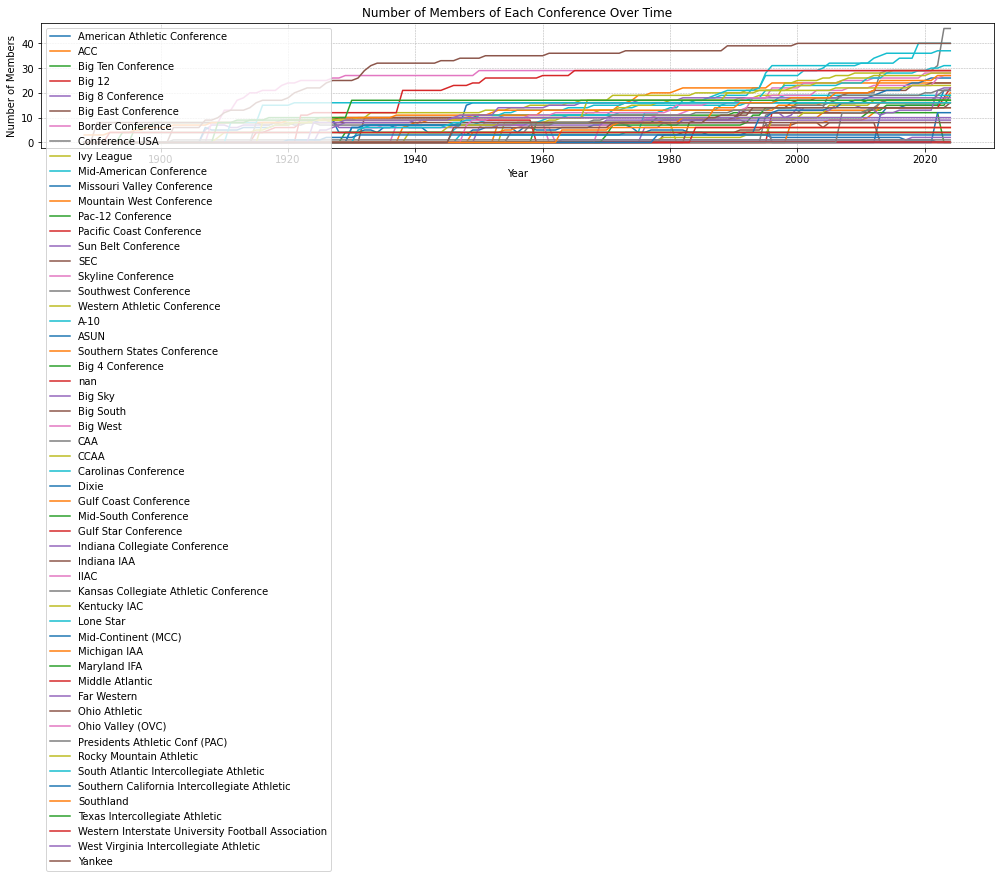

In [35]:
# Reload the data
cfb_data = master_df

# Convert 'Joined' and 'Left' columns to datetime format
cfb_data['Joined'] = pd.to_datetime(cfb_data['Joined'], format='%Y', errors='coerce')
cfb_data['Left'] = pd.to_datetime(cfb_data['Left'], format='%Y', errors='coerce')

# Recreate the yearly membership dataframe
start_year = cfb_data['Joined'].min().year
end_year = cfb_data['Joined'].max().year
data_dict = {}
for year in range(start_year, end_year + 1):
    yearly_data = {}
    for conference in cfb_data['Conference'].unique():
        members = cfb_data[(cfb_data['Conference'] == conference) & 
                           (cfb_data['Joined'].dt.year <= year) & 
                           ((cfb_data['Left'].isnull()) | (cfb_data['Left'].dt.year > year))]['Institution'].tolist()
        yearly_data[conference] = members
    data_dict[year] = yearly_data
yearly_members_df_corrected = pd.DataFrame.from_dict(data_dict, orient='index')

# Compute the number of members for each conference over the years
membership_counts = yearly_members_df_corrected.applymap(len)

# Plotting the membership counts over time
plt.figure(figsize=(14, 8))
for column in membership_counts.columns:
    plt.plot(membership_counts.index, membership_counts[column], label=column, marker='', linewidth=1.5)

# Adding legend, labels and title
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of Members')
plt.title('Number of Members of Each Conference Over Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()


In [36]:
## Manully add a new conference to the yearly_members_df_corrected dataframe
# # Conference is called PROTO-Ivy League started in 1933 and ending 1954
# Members ['Brown', 'Columbia', 'Cornell', 'Dartmouth', 'Harvard', 'Pennsylvania', 'Princeton', 'Yale']

# Create column for the new conference
yearly_members_df_corrected['PROTO-Ivy League'] = ''

# add the list of teams to the new column for the years 1933 to 1954
def set_proto_ivy_league(year):
    if 1933 <= year <= 1954:
        return ['Brown', 'Columbia', 'Cornell', 'Dartmouth', 'Harvard', 'Pennsylvania', 'Princeton', 'Yale']
    else:
        return []

yearly_members_df_corrected['PROTO-Ivy League'] = yearly_members_df_corrected.index.to_series().apply(set_proto_ivy_league)




In [37]:
# Save as csv
yearly_members_df_corrected.to_csv('..\data\yearly_conference_members.csv', index=True)

In [38]:
# ## extract tables with pandas
# SEC_tables = pd.read_html(SEC)
# ACC_tables = pd.read_html(ACC)
# # B1G_tables = pd.read_html(B1G)
# # PAC12_tables = pd.read_html(PAC12)
# BIG12_tables = pd.read_html(BIG12)
# # AAC_tables = pd.read_html(AAC)
# MWC_tables = pd.read_html(MWC)
# MAC_tables = pd.read_html(MAC)
# CUSA_tables = pd.read_html(CUSA)
# SBC_tables = pd.read_html(SBC)

# SWC_tables = pd.read_html(SWC)
# WAC_tables = pd.read_html(WAC)
# BIG8_tables = pd.read_html(BIG8)
# # BIGEAST_tables = pd.read_html(BIGEAST)
# IVY_tables = pd.read_html(IVY)
# PCC_tables = pd.read_html(PCC)
# BORDER_tables = pd.read_html(BORDER)
# MVC_tables = pd.read_html(MVC)
# SKYLINE_tables = pd.read_html(SKYLINE)


In [39]:
## Extract all the tables that list "Current Members" and "Former Members" from each conference's Wikipedia page
## Store the tables in a list

# tables = []

# for url in urls:
#     response = requests.get(url)
#     soup = BeautifulSoup(response.text, 'html.parser')
#     tables.append(soup.find_all('table', class_='wikitable'))

# ## Create a list of the current members of each conference
## Create a list of the former members of each conference
